In [1]:
import numpy as np
import pandas as pd
import requests, bs4
import xml.etree.ElementTree as ET
import xmltodict
import json
import csv
import sys
import copy
from lxml import html
from urllib.request import Request, urlopen
from urllib.parse import urlencode, quote_plus, unquote

In [2]:
url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson'
API_KEY = unquote('')

queryParams = '?' + urlencode(
    { 
        quote_plus('serviceKey') : API_KEY, 
        quote_plus('startCreateDt') : '20200303', 
        quote_plus('endCreateDt') : '20201216' 
    }
)

response = requests.get(url + queryParams).text.encode('utf-8')
xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')

In [3]:
url + queryParams

'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson?serviceKey=&startCreateDt=20200303&endCreateDt=20201216'

In [4]:
rows = xmlobj.findAll('item')
rowList = []
nameList = []
columnList = []

rowsLen = len(rows)
for i in range(0, rowsLen):
    columns = rows[i].find_all()
    
    columnsLen = len(columns)
    for j in range(0, columnsLen):
        # 첫 번째 행 데이터 값 수집 시에만 컬럼 값을 저장한다. (어차피 rows[0], rows[1], ... 모두 컬럼헤더는 동일한 값을 가지기 때문에 매번 반복할 필요가 없다.)
        if i == 0:
            nameList.append(columns[j].name)
        # 컬럼값은 모든 행의 값을 저장해야한다.    
        eachColumn = columns[j].text
        columnList.append(eachColumn)
    rowList.append(columnList)
    columnList = []    # 다음 row의 값을 넣기 위해 비워준다. (매우 중요!!)
    
raw_data = pd.DataFrame(rowList, columns=nameList)

In [5]:
raw_data

,accDefRate,accExamCnt,accExamCompCnt,careCnt,clearCnt,createDt,deathCnt,decideCnt,examCnt,resutlNegCnt,seq,stateDt,stateTime,updateDt
0,1.3388980799,3488769,3393985,11883,32947,2020-12-16 09:37:53.572,612,45442,94784,3348543,355,20201216,00:00,null
1,1.3251897470,3441220,3347747,11205,32559,2020-12-15 09:34:38.398,600,44364,93473,3303383,354,20201215,00:00,null
2,1.3145929369,3397039,3307792,10795,32102,2020-12-14 09:38:10.035,587,43484,89247,3264308,353,20201214,00:00,null
3,1.3020685858,3374595,3284466,10372,31814,2020-12-13 09:48:21.971,580,42766,90129,3241700,352,20201213,00:00,null
4,1.2790205208,3349864,3263122,9665,31493,2020-12-12 09:19:01.382,578,41736,86742,3221386,351,20201212,00:00,null
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,4.2675428362,178189,158569,6605,118,2020-03-07 11:00:45.45,44,6767,19620,151802,66,20200307,00:00,2020-03-09 13:36:26.26
292,4.3972345844,164740,142908,6134,108,2020-03-06 12:55:44.44,42,6284,21832,136624,65,20200306,00:00,2020-03-09 14:05:01.01
293,4.6227481540,146541,124731,5643,88,2020-03-05 10:15:12.12,35,5766,21810,118965,64,20200305,00:00,2020-03-09 14:06:01.01
294,4.9199855946,136707,108293,5255,41,2020-03-04 10:21:44.44,32,5328,28414,102965,63,20200304,00:00,2020-03-09 14:06:59.59


In [6]:
result = raw_data.loc[::-1].reset_index(drop=True)


In [7]:
result.to_csv('corona_raw.csv')

In [8]:
#clearCnt가 윗행과 차이가 없으면 지워버림
clearlist = []
for i in range(1, len(result)):
    if result.iloc[i-1].stateDt == result.iloc[i].stateDt:
        clearlist.append(i-1)
    if result.iloc[i-1].stateDt > result.iloc[i].stateDt:
        temp = copy.deepcopy(result.iloc[i-1])
        result.iloc[i-1] = result.iloc[i]
        result.iloc[i] = temp

print(clearlist)
for i in clearlist:
    result.drop(i, inplace=True)

[21, 31, 55, 56, 215, 228, 278]


In [9]:
#잘못 입력된 값 바꾸기
result.drop(54, inplace=True)

In [10]:
result.to_csv('temp1.csv')

In [11]:
result.decideCnt = result.decideCnt.astype('int')
result.clearCnt = result.clearCnt.astype('int')
result.examCnt = result.examCnt.astype('int')
result.careCnt = result.careCnt.astype('int')
result.resutlNegCnt = result.resutlNegCnt.astype('int')

todayCnt = (result.decideCnt - result.decideCnt.shift(1)).fillna(0)
clearCnt = (result.clearCnt - result.clearCnt.shift(1)).fillna(0)
examCnt = result.examCnt.shift(1).fillna(0)
careCnt = result.careCnt.shift(1).fillna(0)
negativeCnt = (result.resutlNegCnt - result.resutlNegCnt.shift(1)).fillna(0)

In [12]:
todayCnt

0         0.0
1       516.0
2       438.0
3       518.0
4       483.0
        ...  
291     950.0
292    1030.0
293     718.0
294     880.0
295    1078.0
Name: decideCnt, Length: 288, dtype: float64

In [13]:
df_corona = pd.DataFrame()
df_corona['todayCnt'] = todayCnt
df_corona['clearCnt'] = clearCnt
df_corona['examCnt'] = examCnt
df_corona['careCnt'] = careCnt
df_corona['nagativeCnt'] = negativeCnt
df_corona.drop(0, inplace=True)

In [14]:
df_corona

,todayCnt,clearCnt,examCnt,careCnt,nagativeCnt
1,516.0,7.0,35555.0,4750.0,17481.0
2,438.0,47.0,28414.0,5255.0,16000.0
3,518.0,20.0,21810.0,5643.0,17659.0
4,483.0,10.0,21832.0,6134.0,15178.0
5,367.0,12.0,19620.0,6605.0,10206.0
...,...,...,...,...,...
291,950.0,336.0,77688.0,9057.0,28647.0
292,1030.0,321.0,86742.0,9665.0,20314.0
293,718.0,288.0,90129.0,10372.0,22608.0
294,880.0,457.0,89247.0,10795.0,39075.0


In [15]:
df_corona.to_csv('corona_data.csv')

In [16]:
f = open('corona_data.csv', 'r', encoding='utf-8')
rdr = csv.reader(f)
lines = []
for line in rdr:
    if line[0] == "":
        continue
    line.pop(0)
    lines.append(line)
f = open('corona_data.csv','w', newline='')
wr = csv.writer(f)
wr.writerows(lines)
f.close()


In [17]:
import shutil
src = './corona_data.csv'
dir = 'C:\Temp'
shutil.copy(src, dir)

'C:\\Temp\\corona_data.csv'

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 1080x720 with 0 Axes>

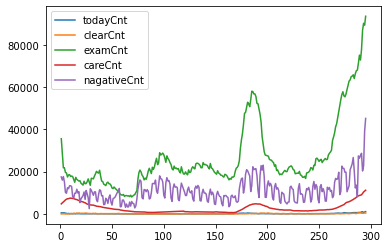

In [19]:
plt.figure(figsize = (15,10)) 
df_corona.plot()
plt.savefig('./full.png')
plt.show()

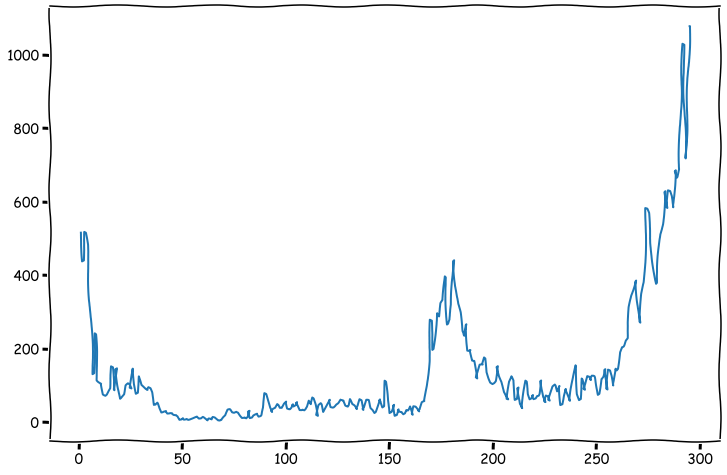

In [20]:
plt.xkcd()
df_corona['todayCnt'].plot(figsize = (12,8))
plt.savefig('./today.png')
plt.show()